# Notebook 1: Exploratory Data Analysis (EDA) and Data Preparation
## MIMIC-III Clinical Database for Recommendation Systems

**Author:** Data Science Team  
**Date:** November 2025  
**Objective:** Complete EDA with data loading, inspection, cleaning, and train-test split

---

## Workflow Overview

```
┌──────────────────────────────────────────────────────┐
│          EDA WORKFLOW PIPELINE                       │
├──────────────────────────────────────────────────────┤
│ 1. DATA LOADING                                      │
│    ↓                                                 │
│ 2. INITIAL INSPECTION (head, info, describe)        │
│    ↓                                                 │
│ 3. MISSING VALUES & DUPLICATES                       │
│    ↓                                                 │
│ 4. OUTLIERS DETECTION                                │
│    ↓                                                 │
│ 5. EXPLORATORY ANALYSIS (Distributions)             │
│    ↓                                                 │
│ 6. CORRELATION ANALYSIS                              │
│    ↓                                                 │
│ 7. CLASS BALANCING ASSESSMENT                        │
│    ↓                                                 │
│ 8. DATA CLEANING & PREPROCESSING                     │
│    ↓                                                 │
│ 9. TRAIN-TEST SPLIT & EXPORT                         │
│    ↓                                                 │
│ 10. FINAL SUMMARY REPORT                             │
└──────────────────────────────────────────────────────┘
```

## Section 1: Import Required Libraries

In [1]:
# Import essential libraries for EDA and data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
import json
from datetime import datetime
from scipy import stats
from scipy.stats import skew, kurtosis

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Configure visualization
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print('✓ All libraries imported successfully!')
print(f'Execution timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

✓ All libraries imported successfully!
Execution timestamp: 2025-12-03 20:48:08


## Section 2: Load Dataset from MIMIC-III

In [2]:
# Load MIMIC-III clinical database tables
import kagglehub
from kagglehub import KaggleDatasetAdapter

DATASET_NAME = 'ihssanened/mimic-iii-clinical-databaseopen-access'

def load_mimic_table(file_name, date_col=None):
    """Load a single MIMIC-III table using KaggleHub."""
    try:
        print(f'  Loading: {file_name}...', end=' ')
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            DATASET_NAME,
            file_name
        )
        if date_col and date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        print(f'✓ {df.shape[0]:,} rows × {df.shape[1]} columns')
        return df
    except Exception as e:
        print(f'✗ Error loading {file_name}')
        return None

print('\n=== Loading MIMIC-III Tables ===\n')
df_admissions = load_mimic_table('admissions.csv', date_col='admittime')
df_patients = load_mimic_table('patients.csv')
df_labevents = load_mimic_table('labevents.csv')
df_d_labitems = load_mimic_table('d_labitems.csv')

if df_admissions is None or df_patients is None:
    print('\nCritical tables failed to load!')
else:
    print('\n✓ All critical tables loaded!')


=== Loading MIMIC-III Tables ===

  Loading: admissions.csv... ✓ 129 rows × 19 columns
  Loading: patients.csv... ✓ 100 rows × 8 columns
  Loading: labevents.csv... ✓ 76,074 rows × 9 columns
  Loading: d_labitems.csv... ✓ 753 rows × 6 columns

✓ All critical tables loaded!


## Section 3: Initial Data Inspection (head, info, describe)

In [3]:
# Perform initial inspection of key tables
def inspect_table(df, name):
    print(f'\n{"="*80}')
    print(f'TABLE: {name.upper()}')
    print(f'{"="*80}')
    print(f'\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns')
    print(f'\nFirst 5 rows:')
    display(df.head())
    print(f'\nData types and missing values:')
    print(df.info())
    print(f'\nDescriptive statistics:')
    display(df.describe(include='all').round(2))

if df_admissions is not None:
    inspect_table(df_admissions, 'admissions')
if df_patients is not None:
    inspect_table(df_patients, 'patients')


TABLE: ADMISSIONS

Shape: 129 rows × 19 columns

First 5 rows:


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                129 non-null    int64         
 1   subject_id            129 non-null    int64         
 2   hadm_id               129 non-null    int64         
 3   admittime             129 non-null    datetime64[ns]
 4   dischtime             129 non-null    object        
 5   deathtime             40 non-null     object        
 6   admission_type        129 non-null    object        
 7   admission_location    129 non-null    object        
 8   discharge_location    129 non-null    object        
 9   insurance             129 non-null    object        
 10  language              81 non-null     object        
 11  religion              128 non-null    object        
 12  marital_status        113 non-null    object  

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
count,129.00,129.00,129.00,129,129,40,129,129,129,129,81,128,113,129,92,92,129,129.00,129.00
unique,NaN,NaN,NaN,NaN,129,40,3,5,10,4,5,10,6,9,92,92,95,NaN,NaN
top,NaN,NaN,NaN,NaN,2164-11-01 17:15:00,2126-08-28 18:59:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,NaN,NaN
freq,NaN,NaN,NaN,NaN,1,1,119,81,40,98,58,59,60,86,1,1,10,NaN,NaN
mean,28036.44,28010.41,152343.44,2154-04-08 23:17:16.744185856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31,0.99
min,12258.00,10006.00,100375.00,2102-08-29 07:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00
25%,12339.00,10088.00,128293.00,2128-11-04 16:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00
50%,39869.00,40310.00,157235.00,2150-08-22 17:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00
75%,40463.00,42135.00,174739.00,2180-03-15 22:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00
max,41092.00,44228.00,199395.00,2202-10-03 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00



TABLE: PATIENTS

Shape: 100 rows × 8 columns

First 5 rows:


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       100 non-null    int64 
 1   subject_id   100 non-null    int64 
 2   gender       100 non-null    object
 3   dob          100 non-null    object
 4   dod          100 non-null    object
 5   dod_hosp     70 non-null     object
 6   dod_ssn      77 non-null     object
 7   expire_flag  100 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 6.4+ KB
None

Descriptive statistics:


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
count,100.00,100.00,100,100,100,70,77,100.0
unique,NaN,NaN,2,99,100,70,77,NaN
top,NaN,NaN,F,2058-04-23 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,NaN
freq,NaN,NaN,55,2,1,1,1,NaN
mean,20452.58,26162.33,NaN,NaN,NaN,NaN,NaN,1.0
std,10982.04,16201.83,NaN,NaN,NaN,NaN,NaN,0.0
min,9467.00,10006.00,NaN,NaN,NaN,NaN,NaN,1.0
25%,9526.50,10068.50,NaN,NaN,NaN,NaN,NaN,1.0
50%,20209.00,25128.00,NaN,NaN,NaN,NaN,NaN,1.0
75%,31391.25,42276.50,NaN,NaN,NaN,NaN,NaN,1.0


## Section 4: Missing Values and Duplicates Detection


Missing Values Analysis: ADMISSIONS

Total missing: 228


,Column,Missing_Count,Missing_Percentage
deathtime,deathtime,89,68.99
language,language,48,37.21
edouttime,edouttime,37,28.68
edregtime,edregtime,37,28.68
marital_status,marital_status,16,12.40
religion,religion,1,0.78
row_id,row_id,0,0.00
hospital_expire_flag,hospital_expire_flag,0,0.00
diagnosis,diagnosis,0,0.00
ethnicity,ethnicity,0,0.00


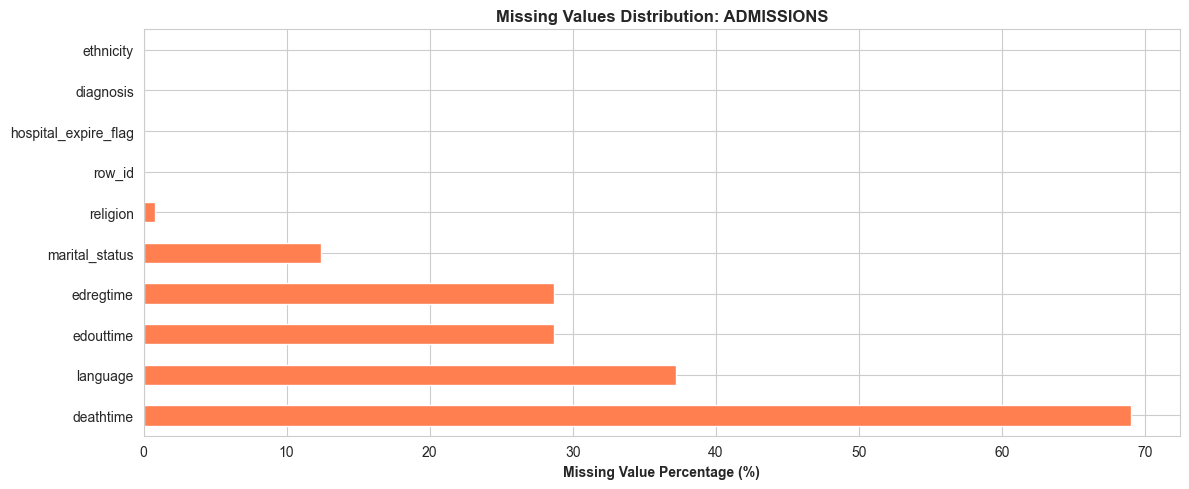


**Interpretation:** This chart shows the percentage of missing values for each column.
High percentages indicate sparse data, which is common in clinical datasets.

Duplicates Analysis: ADMISSIONS
Total duplicate rows: 0
Duplicate percentage: 0.00%

Missing Values Analysis: LABEVENTS

Total missing: 79,053


,Column,Missing_Count,Missing_Percentage
flag,flag,46337,60.91
hadm_id,hadm_id,14262,18.75
valueuom,valueuom,9405,12.36
valuenum,valuenum,9044,11.89
value,value,5,0.01
row_id,row_id,0,0.00
subject_id,subject_id,0,0.00
itemid,itemid,0,0.00
charttime,charttime,0,0.00


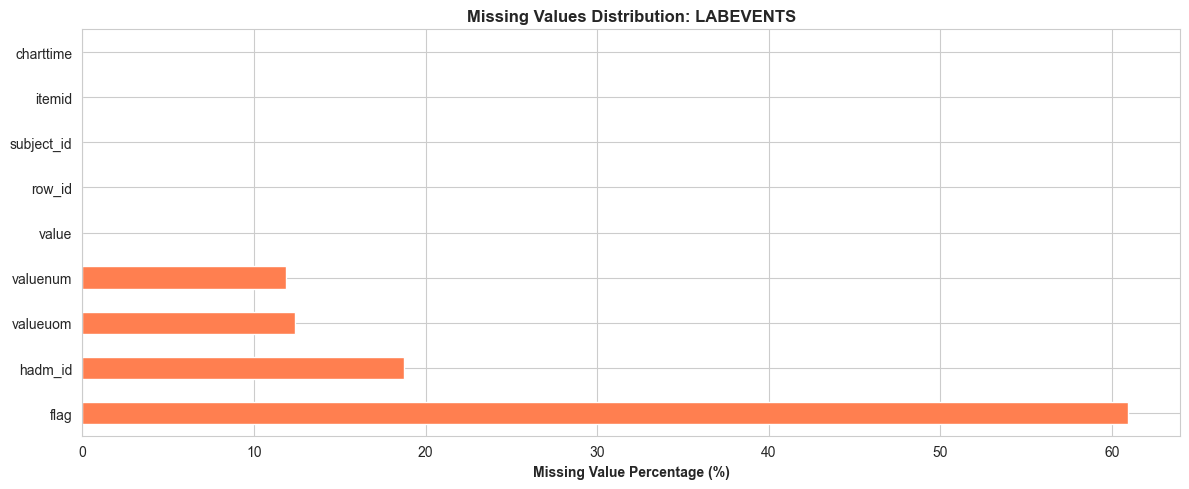


**Interpretation:** This chart shows the percentage of missing values for each column.
High percentages indicate sparse data, which is common in clinical datasets.


In [4]:
# Analyze missing values
def analyze_missing(df, name):
    print(f'\n{"="*80}')
    print(f'Missing Values Analysis: {name.upper()}')
    print(f'{"="*80}')
    
    missing_summary = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    }).sort_values('Missing_Percentage', ascending=False)
    
    print(f'\nTotal missing: {df.isnull().sum().sum():,}')
    display(missing_summary.head(10))
    
    # Visualization
    missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(10)
    if len(missing_pct) > 0:
        fig, ax = plt.subplots(figsize=(12, 5))
        missing_pct.plot(kind='barh', ax=ax, color='coral')
        ax.set_xlabel('Missing Value Percentage (%)', fontweight='bold')
        ax.set_title(f'Missing Values Distribution: {name.upper()}', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print(f'\n**Interpretation:** This chart shows the percentage of missing values for each column.')
        print(f'High percentages indicate sparse data, which is common in clinical datasets.')

# Analyze duplicates
def analyze_duplicates(df, name):
    print(f'\n{"="*80}')
    print(f'Duplicates Analysis: {name.upper()}')
    print(f'{"="*80}')
    dup_count = df.duplicated().sum()
    print(f'Total duplicate rows: {dup_count}')
    print(f'Duplicate percentage: {(dup_count/len(df)*100):.2f}%')

if df_admissions is not None:
    analyze_missing(df_admissions, 'admissions')
    analyze_duplicates(df_admissions, 'admissions')

if df_labevents is not None:
    analyze_missing(df_labevents, 'labevents')

## Section 5: Outliers Detection using Box Plots


Outliers Detection in Laboratory Values


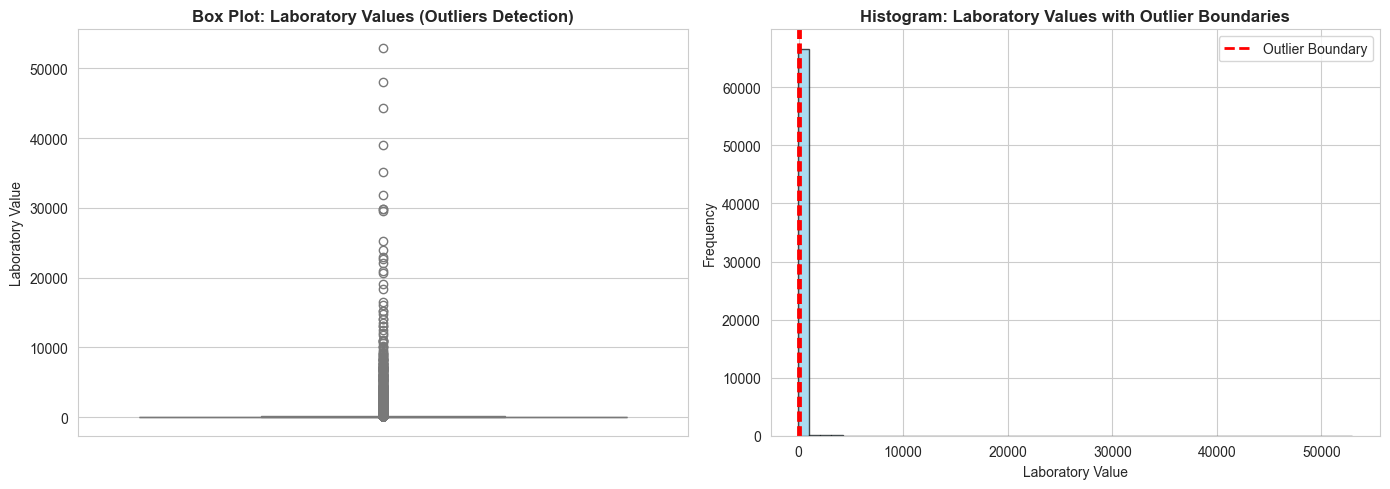


**Interpretation:**
• Total values: 67,030
• Outliers detected (IQR method): 4,835 (7.21%)
• Lower bound: -79.50
• Upper bound: 143.70
• Outliers are values beyond 1.5×IQR from Q1 and Q3, indicated by the red dashed lines.


In [5]:
# Detect and visualize outliers
if df_labevents is not None and 'valuenum' in df_labevents.columns:
    print('\nOutliers Detection in Laboratory Values')
    print('='*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot for outliers
    sns.boxplot(y=df_labevents['valuenum'].dropna(), ax=axes[0], color='lightblue')
    axes[0].set_title('Box Plot: Laboratory Values (Outliers Detection)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Laboratory Value')
    
    # Histogram with outlier regions
    Q1 = df_labevents['valuenum'].quantile(0.25)
    Q3 = df_labevents['valuenum'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    axes[1].hist(df_labevents['valuenum'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(lower_bound, color='red', linestyle='--', linewidth=2, label='Outlier Boundary')
    axes[1].axvline(upper_bound, color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Histogram: Laboratory Values with Outlier Boundaries', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Laboratory Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    outlier_count = ((df_labevents['valuenum'] < lower_bound) | (df_labevents['valuenum'] > upper_bound)).sum()
    print(f'\n**Interpretation:**')
    print(f'• Total values: {len(df_labevents["valuenum"].dropna()):,}')
    print(f'• Outliers detected (IQR method): {outlier_count:,} ({outlier_count/len(df_labevents["valuenum"].dropna())*100:.2f}%)')
    print(f'• Lower bound: {lower_bound:.2f}')
    print(f'• Upper bound: {upper_bound:.2f}')
    print(f'• Outliers are values beyond 1.5×IQR from Q1 and Q3, indicated by the red dashed lines.')

## Section 6: Exploratory Analysis - Distributions and Histograms


Exploratory Data Analysis: Variable Distributions

[1] Distribution of Laboratory Values


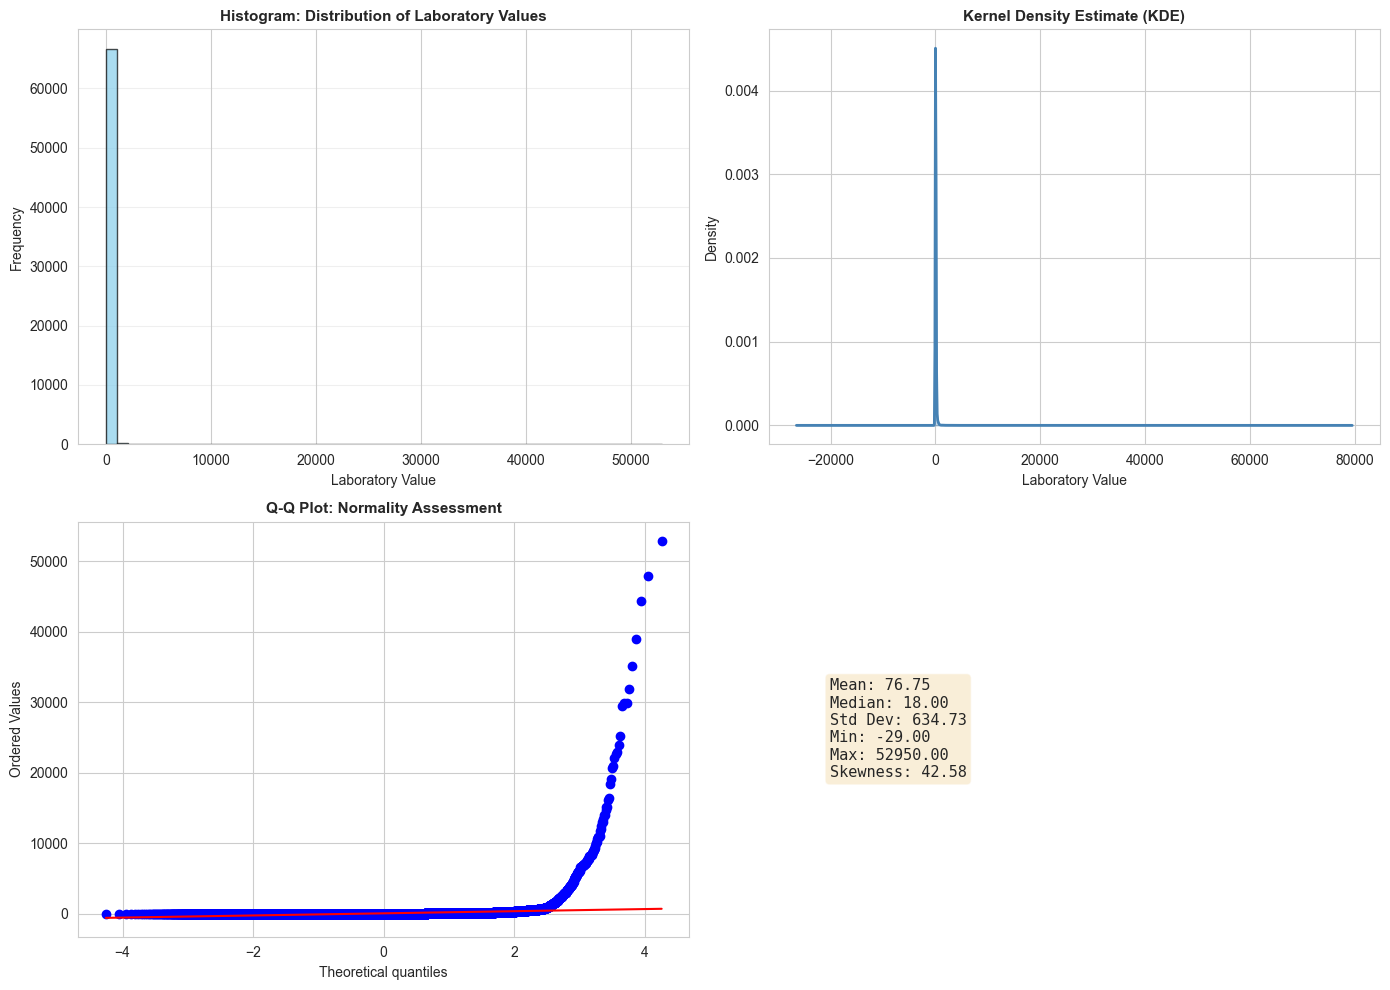


**Interpretation:**
• The histogram shows the frequency distribution of laboratory values.
• The KDE plot provides a smooth estimate of the probability density.
• The Q-Q plot compares against normal distribution (points on diagonal = normal).
• Mean: 76.75, Median: 18.00, Std Dev: 634.73
• Skewness: 42.58 (positive = right-skewed, negative = left-skewed)


In [6]:
# Analyze distributions
print('\nExploratory Data Analysis: Variable Distributions')
print('='*80)

if df_labevents is not None and 'valuenum' in df_labevents.columns:
    print('\n[1] Distribution of Laboratory Values')
    lab_values = df_labevents['valuenum'].dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram
    axes[0, 0].hist(lab_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Histogram: Distribution of Laboratory Values', fontsize=11, fontweight='bold')
    axes[0, 0].set_xlabel('Laboratory Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # KDE plot
    lab_values.plot(kind='kde', ax=axes[0, 1], color='steelblue', linewidth=2)
    axes[0, 1].fill_between(axes[0, 1].get_lines()[0].get_xdata(), 
                            axes[0, 1].get_lines()[0].get_ydata(), alpha=0.3, color='steelblue')
    axes[0, 1].set_title('Kernel Density Estimate (KDE)', fontsize=11, fontweight='bold')
    axes[0, 1].set_xlabel('Laboratory Value')
    axes[0, 1].set_ylabel('Density')
    
    # Q-Q plot
    stats.probplot(lab_values, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Normality Assessment', fontsize=11, fontweight='bold')
    
    # Summary statistics text box
    stats_text = f'Mean: {lab_values.mean():.2f}\nMedian: {lab_values.median():.2f}\nStd Dev: {lab_values.std():.2f}\n'
    stats_text += f'Min: {lab_values.min():.2f}\nMax: {lab_values.max():.2f}\nSkewness: {skew(lab_values):.2f}'
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), family='monospace')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'\n**Interpretation:**')
    print(f'• The histogram shows the frequency distribution of laboratory values.')
    print(f'• The KDE plot provides a smooth estimate of the probability density.')
    print(f'• The Q-Q plot compares against normal distribution (points on diagonal = normal).')
    print(f'• Mean: {lab_values.mean():.2f}, Median: {lab_values.median():.2f}, Std Dev: {lab_values.std():.2f}')
    print(f'• Skewness: {skew(lab_values):.2f} (positive = right-skewed, negative = left-skewed)')


[2] Distribution of Patient Demographics


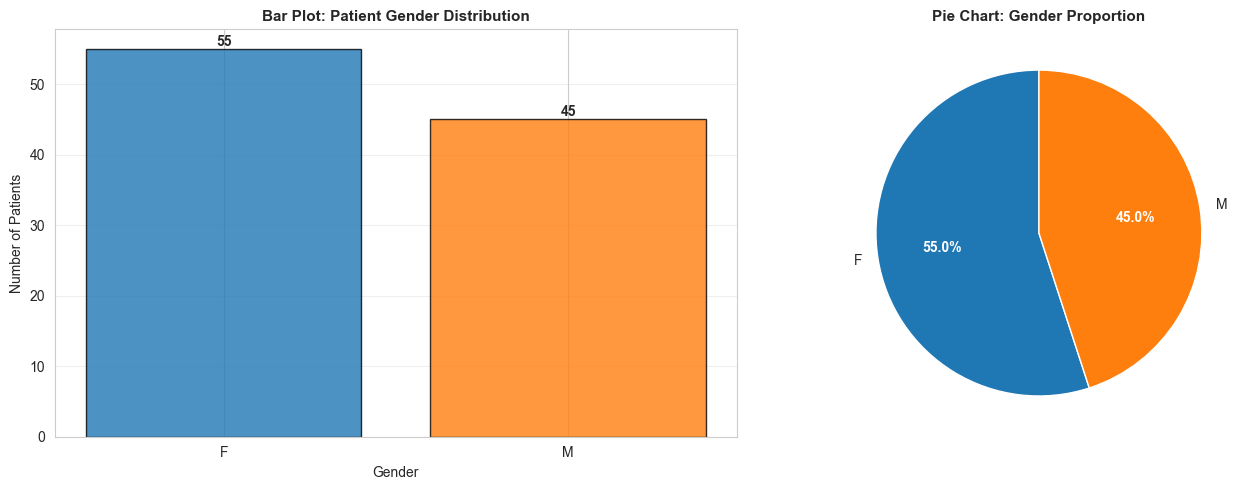


**Interpretation:**
• Total patients: 100
• F: 55 (55.0%)
• M: 45 (45.0%)


In [7]:
# Patient demographics analysis
if df_patients is not None and 'gender' in df_patients.columns:
    print('\n[2] Distribution of Patient Demographics')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gender distribution - Bar plot
    gender_counts = df_patients['gender'].value_counts()
    colors = ['#1f77b4', '#ff7f0e']
    bars = axes[0].bar(gender_counts.index, gender_counts.values, color=colors, edgecolor='black', alpha=0.8)
    axes[0].set_title('Bar Plot: Patient Gender Distribution', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Gender')
    axes[0].set_ylabel('Number of Patients')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    # Gender distribution - Pie chart
    colors_pie = ['#1f77b4', '#ff7f0e']
    wedges, texts, autotexts = axes[1].pie(gender_counts.values, labels=gender_counts.index, 
                                            autopct='%1.1f%%', colors=colors_pie, startangle=90)
    axes[1].set_title('Pie Chart: Gender Proportion', fontsize=11, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f'\n**Interpretation:**')
    print(f'• Total patients: {len(df_patients):,}')
    for gender, count in gender_counts.items():
        pct = count / len(df_patients) * 100
        print(f'• {gender}: {count:,} ({pct:.1f}%)')

## Section 7: Correlation Analysis Between Clinical Variables


Correlation Analysis: Clinical Variables


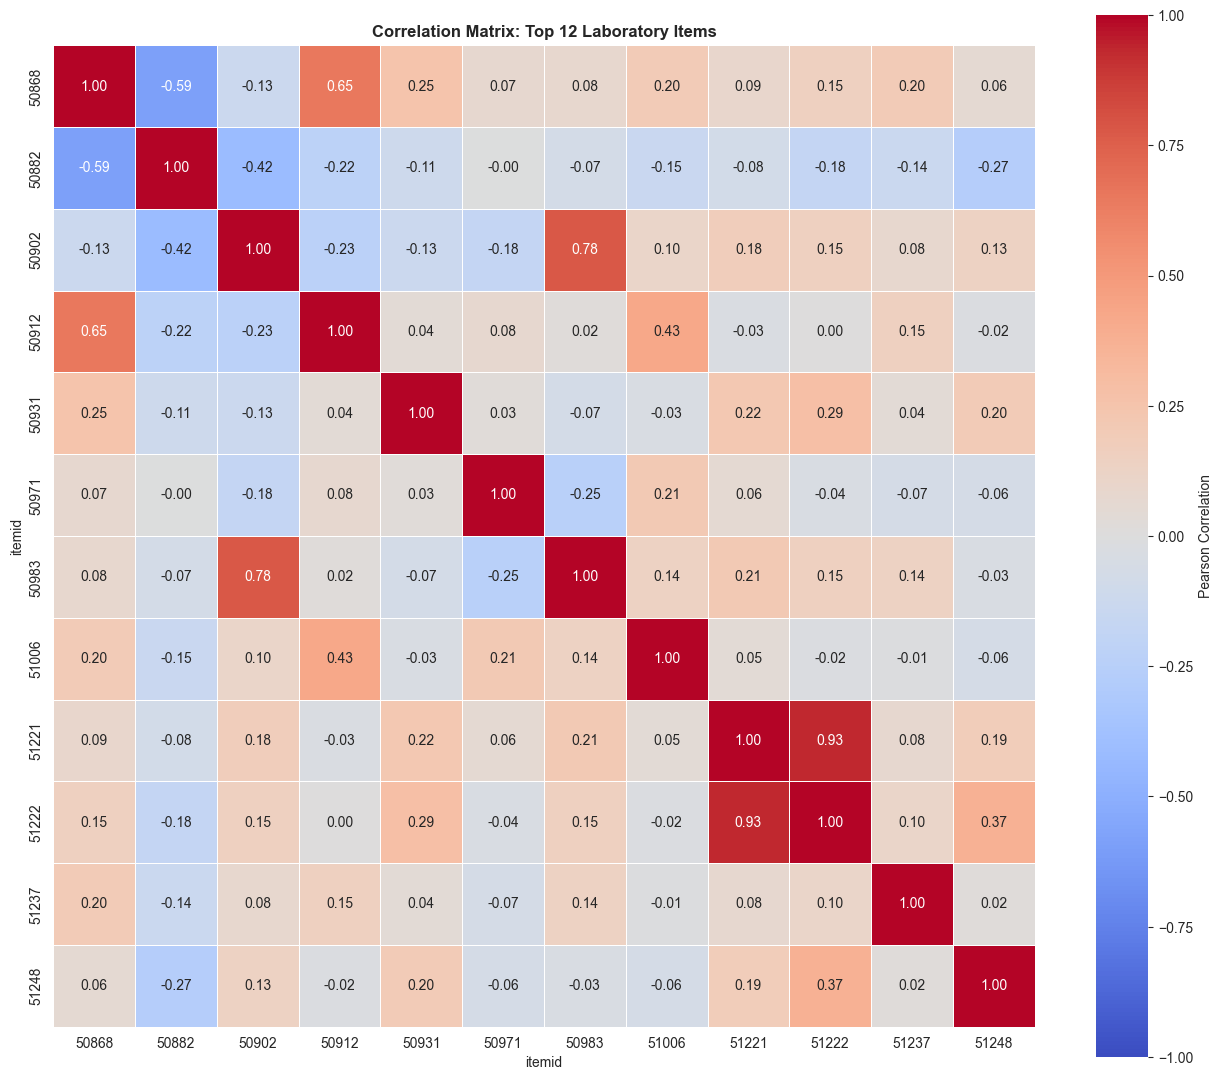


**Interpretation:**
• This heatmap shows pairwise Pearson correlations between the top laboratory items.
• Values close to +1 (dark red) indicate strong positive correlation.
• Values close to -1 (dark blue) indicate strong negative correlation.
• Values close to 0 (white) indicate weak or no linear correlation.

• Top 5 strongest correlations (excluding diagonal):
  1. Items 51221 ↔ 51222: r = 0.933
  2. Items 50902 ↔ 50983: r = 0.779
  3. Items 50868 ↔ 50912: r = 0.654
  4. Items 50868 ↔ 50882: r = -0.586
  5. Items 50912 ↔ 51006: r = 0.426


In [8]:
# Correlation analysis
print('\nCorrelation Analysis: Clinical Variables')
print('='*80)

if df_labevents is not None and 'subject_id' in df_labevents.columns:
    # Create pivot table
    df_lab_clean = df_labevents[['subject_id', 'itemid', 'valuenum']].dropna()
    pivot_data = df_lab_clean.pivot_table(
        index='subject_id',
        columns='itemid',
        values='valuenum',
        aggfunc='mean'
    )
    
    # Select top features
    top_items = pivot_data.notna().sum().nlargest(12).index
    pivot_subset = pivot_data[top_items].dropna(how='all').fillna(pivot_data[top_items].mean())
    
    if pivot_subset.shape[0] > 2:
        # Correlation matrix
        corr_matrix = pivot_subset.corr()
        
        fig, ax = plt.subplots(figsize=(13, 11))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   square=True, ax=ax, cbar_kws={'label': 'Pearson Correlation'}, 
                   vmin=-1, vmax=1, linewidths=0.5)
        ax.set_title('Correlation Matrix: Top 12 Laboratory Items', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f'\n**Interpretation:**')
        print(f'• This heatmap shows pairwise Pearson correlations between the top laboratory items.')
        print(f'• Values close to +1 (dark red) indicate strong positive correlation.')
        print(f'• Values close to -1 (dark blue) indicate strong negative correlation.')
        print(f'• Values close to 0 (white) indicate weak or no linear correlation.')
        print(f'\n• Top 5 strongest correlations (excluding diagonal):')
        
        # Find top correlations
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_pairs.append({
                    'Item1': corr_matrix.columns[i],
                    'Item2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
        
        top_corrs = sorted(corr_pairs, key=lambda x: abs(x['Correlation']), reverse=True)[:5]
        for idx, corr in enumerate(top_corrs, 1):
            print(f'  {idx}. Items {corr["Item1"]} ↔ {corr["Item2"]}: r = {corr["Correlation"]:.3f}')

## Section 8: Class Balancing Assessment


Class Balancing Assessment

Target Variable: Hospital Mortality (hospital_expire_flag)
Total patients: 100

Class Distribution:
  Class 0 (Survived): 67 (67.00%)
  Class 1 (Died): 33 (33.00%)

Imbalance Ratio: 2.03:1


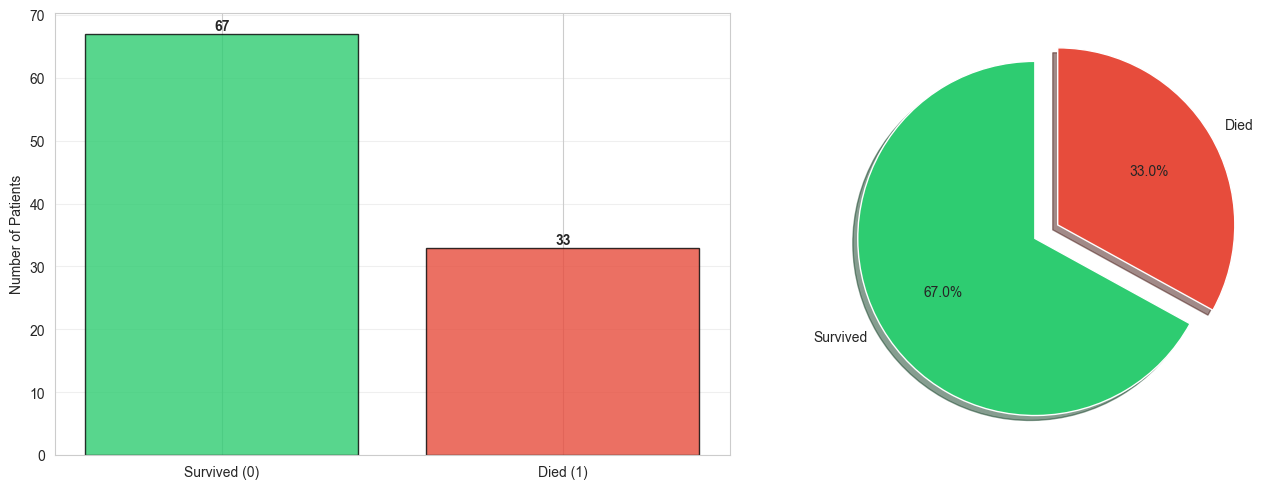


**Interpretation:**
  SIGNIFICANT CLASS IMBALANCE DETECTED!
   Recommendation: Apply balancing techniques
   • SMOTE (Synthetic Minority Over-sampling): Recommended
   • Random Under-sampling: Alternative approach
   • Weighted loss functions: For model training


In [19]:
# Class balancing analysis
print('\nClass Balancing Assessment')
print('='*80)

if df_admissions is not None and 'hospital_expire_flag' in df_admissions.columns:
    # Get unique admissions per patient
    df_admit_unique = df_admissions.drop_duplicates(subset=['subject_id'], keep='first')
    mortality = df_admit_unique['hospital_expire_flag'].value_counts().sort_index()
    mortality_pct = mortality / len(df_admit_unique) * 100
    
    print(f'\nTarget Variable: Hospital Mortality (hospital_expire_flag)')
    print(f'Total patients: {len(df_admit_unique):,}')
    print(f'\nClass Distribution:')
    print(f'  Class 0 (Survived): {mortality[0]:,} ({mortality_pct[0]:.2f}%)')
    print(f'  Class 1 (Died): {mortality[1]:,} ({mortality_pct[1]:.2f}%)')
    
    imbalance_ratio = max(mortality.values) / min(mortality.values)
    print(f'\nImbalance Ratio: {imbalance_ratio:.2f}:1')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot
    colors_bar = ['#2ecc71', '#e74c3c']  # Green for survived, red for died
    bars = axes[0].bar(['Survived (0)', 'Died (1)'], mortality.values, color=colors_bar, edgecolor='black', alpha=0.8)
    axes[0].set_title('', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Number of Patients')
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    explode = (0.05, 0.1)
    axes[1].pie(mortality.values, labels=['Survived', 'Died'], autopct='%1.1f%%',
               colors=colors_bar, explode=explode, startangle=90, shadow=True)
    axes[1].set_title('', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f'\n**Interpretation:**')
    if imbalance_ratio > 2:
        print(f'  SIGNIFICANT CLASS IMBALANCE DETECTED!')
        print(f'   Recommendation: Apply balancing techniques')
        print(f'   • SMOTE (Synthetic Minority Over-sampling): Recommended')
        print(f'   • Random Under-sampling: Alternative approach')
        print(f'   • Weighted loss functions: For model training')
    else:
        print(f'✓ Classes are relatively balanced. Balancing may not be necessary.')

## Section 9: Data Cleaning and Preprocessing

In [10]:
# Data cleaning and preprocessing
print('\nData Cleaning and Preprocessing')
print('='*80)

# Step 1: Clean admissions
if df_admissions is not None:
    print('\n[Step 1] Cleaning Admissions Table')
    df_admit_clean = df_admissions.drop_duplicates()
    df_admit_first = df_admit_clean.drop_duplicates(subset=['subject_id'], keep='first')
    print(f'  Original records: {len(df_admissions):,}')
    print(f'  After deduplication: {len(df_admit_clean):,}')
    print(f'  First admission per patient: {len(df_admit_first):,}')

# Step 2: Create feature matrix from labevents
if df_labevents is not None:
    print('\n[Step 2] Creating Patient-Laboratory Feature Matrix')
    
    df_lab_valid = df_labevents[['subject_id', 'itemid', 'valuenum']].dropna(subset=['valuenum'])
    print(f'  Valid lab events: {len(df_lab_valid):,}')
    
    # Aggregate by mean
    df_lab_agg = df_lab_valid.groupby(['subject_id', 'itemid'])['valuenum'].mean().reset_index()
    
    # Pivot
    X_matrix = df_lab_agg.pivot(index='subject_id', columns='itemid', values='valuenum')
    print(f'  Feature matrix shape: {X_matrix.shape}')
    
    sparsity_pct = (X_matrix.isnull().sum().sum() / X_matrix.size * 100)
    print(f'  Sparsity: {sparsity_pct:.2f}%')
    
    # Impute with median
    X_matrix_imputed = X_matrix.fillna(X_matrix.median())
    print(f'  After imputation: {X_matrix_imputed.isnull().sum().sum()} missing values')
    
    # Select top features by variance
    top_features = X_matrix_imputed.var().nlargest(25).index
    X_final = X_matrix_imputed[top_features]
    print(f'  Selected top {len(top_features)} features by variance')

# Step 3: Prepare target variable
if df_admit_first is not None and 'hospital_expire_flag' in df_admit_first.columns:
    print('\n[Step 3] Preparing Target Variable')
    
    y_target = df_admit_first.set_index('subject_id')[['hospital_expire_flag']]
    
    # Align X and y
    common_patients = X_final.index.intersection(y_target.index)
    X_aligned = X_final.loc[common_patients]
    y_aligned = y_target.loc[common_patients, 'hospital_expire_flag'].astype(int)
    
    print(f'  Common patients: {len(common_patients):,}')
    print(f'  Final X shape: {X_aligned.shape}')
    print(f'  Final y shape: {y_aligned.shape}')
    print(f'  Target distribution:')
    print(f'    Class 0 (Survived): {(y_aligned == 0).sum():,}')
    print(f'    Class 1 (Died): {(y_aligned == 1).sum():,}')
else:
    X_aligned = X_final
    y_aligned = None
    print('\n  Target variable not available. Using features only.')

print('\n✓ Data preprocessing completed!')


Data Cleaning and Preprocessing

[Step 1] Cleaning Admissions Table
  Original records: 129
  After deduplication: 129
  First admission per patient: 100

[Step 2] Creating Patient-Laboratory Feature Matrix
  Valid lab events: 67,030
  Feature matrix shape: (100, 275)
  Sparsity: 75.96%
  After imputation: 0 missing values
  Selected top 25 features by variance

[Step 3] Preparing Target Variable
  Common patients: 100
  Final X shape: (100, 25)
  Final y shape: (100,)
  Target distribution:
    Class 0 (Survived): 67
    Class 1 (Died): 33

✓ Data preprocessing completed!
  After imputation: 0 missing values
  Selected top 25 features by variance

[Step 3] Preparing Target Variable
  Common patients: 100
  Final X shape: (100, 25)
  Final y shape: (100,)
  Target distribution:
    Class 0 (Survived): 67
    Class 1 (Died): 33

✓ Data preprocessing completed!



Correlation of Features with Target Variable (hospital_expire_flag)


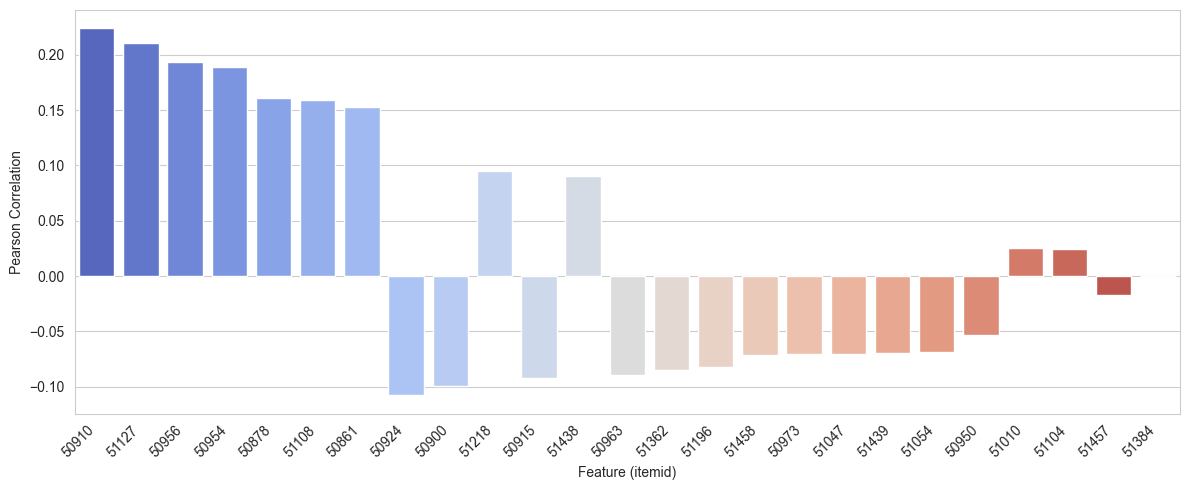


Top 5 features most correlated with the target:
  1. Feature 50910: r = 0.224
  2. Feature 51127: r = 0.211
  3. Feature 50956: r = 0.194
  4. Feature 50954: r = 0.189
  5. Feature 50878: r = 0.161


In [17]:
# Correlation of each feature with the target variable (hospital_expire_flag)
if 'X_aligned' in globals() and 'y_aligned' in globals() and y_aligned is not None:
    print('\nCorrelation of Features with Target Variable (hospital_expire_flag)')
    print('='*80)
    
    # Compute correlation for each feature with the target
    corr_with_target = X_aligned.apply(lambda x: np.corrcoef(x, y_aligned)[0, 1])
    corr_with_target = corr_with_target.sort_values(key=np.abs, ascending=False)
    
    # Display as bar plot
    plt.figure(figsize=(12, 5))
    sns.barplot(x=corr_with_target.index.astype(str), y=corr_with_target.values, palette='coolwarm')
    plt.title('', fontsize=12, fontweight='bold')
    plt.ylabel('Pearson Correlation')
    plt.xlabel('Feature (itemid)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print('\nTop 5 features most correlated with the target:')
    for i, (feat, corr) in enumerate(corr_with_target.head(5).items(), 1):
        print(f'  {i}. Feature {feat}: r = {corr:.3f}')
else:
    print('X_aligned or y_aligned not available. Cannot compute correlation with target.')

## Section 9b: Correlation of Features with Target Variable

This section computes and visualizes the correlation of each laboratory feature with the target variable `hospital_expire_flag` (mortality). This is a key requirement for EDA and model interpretability.

## Section 10: Train-Test Split and Data Export

In [12]:
# Train-test split and export
print('\nTrain-Test Split and Data Export')
print('='*80)

# Create output directory (cross-platform, with safe fallbacks)
from pathlib import Path
import tempfile

# Preferred: project-local directory (where the notebook is running)
project_dir = Path.cwd()
preferred_dir = project_dir / 'processed_data'

def try_make_dir(path: Path):
    try:
        path.mkdir(parents=True, exist_ok=True)
        return True
    except PermissionError:
        return False

if try_make_dir(preferred_dir):
    output_dir = str(preferred_dir)
else:
    # Fallback: user's Desktop (cross-platform home)
    desktop_dir = Path.home() / 'Desktop' / 'IntercicloEstocasticos' / 'ExamenPractico' / 'processed_data'
    if try_make_dir(desktop_dir):
        output_dir = str(desktop_dir)
    else:
        # Last resort: OS temporary directory
        temp_dir = Path(tempfile.mkdtemp(prefix='processed_data_'))
        output_dir = str(temp_dir)
        print('\n[] Preferred locations are not writable; using temporary directory:')
        print(f'    {output_dir}')

print(f'\n[1] Output directory: {output_dir}')

# Perform train-test split
print('\n[2] Stratified Train-Test Split (80-20)')

if y_aligned is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_aligned, y_aligned,
        test_size=0.2,
        random_state=42,
        stratify=y_aligned
    )
else:
    X_train, X_test = train_test_split(
        X_aligned,
        test_size=0.2,
        random_state=42
    )
    y_train = None
    y_test = None

print(f'  Training set: {X_train.shape[0]:,} samples × {X_train.shape[1]} features')
print(f'  Test set: {X_test.shape[0]:,} samples × {X_test.shape[1]} features')

if y_train is not None:
    print(f'\n  Train class distribution:')
    print(f'    Survived: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)')
    print(f'    Died: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)')
    print(f'\n  Test class distribution:')
    print(f'    Survived: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)')
    print(f'    Died: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)')

# Standardize features
print('\n[3] Feature Standardization (StandardScaler)')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
print(f'  Scaling completed (mean=0, std=1)')

# Export datasets
print('\n[4] Exporting Datasets')

# Training set
train_df = X_train_scaled_df.copy()
if y_train is not None:
    train_df['hospital_expire_flag'] = y_train

train_path = os.path.join(output_dir, 'data_train.csv')
train_df.to_csv(train_path)
print(f'  ✓ Training set: {train_path}')

# Test set
test_df = X_test_scaled_df.copy()
if y_test is not None:
    test_df['hospital_expire_flag'] = y_test

test_path = os.path.join(output_dir, 'data_test.csv')
test_df.to_csv(test_path)
print(f'  ✓ Test set: {test_path}')

# Complete dataset
complete_df = pd.concat([train_df, test_df])
complete_df['data_split'] = ['train'] * len(train_df) + ['test'] * len(test_df)

complete_path = os.path.join(output_dir, 'data_prepared.csv')
complete_df.to_csv(complete_path)
print(f'  ✓ Complete dataset: {complete_path}')

# Pickle format
pickle_path = os.path.join(output_dir, 'data_prepared.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump({
        'X_train': X_train_scaled_df,
        'X_test': X_test_scaled_df,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': X_train.columns.tolist()
    }, f)
print(f'  ✓ Pickle file: {pickle_path}')

# Metadata
metadata = {
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features': X_train.shape[1],
    'feature_names': X_train.columns.tolist(),
    'target_variable': 'hospital_expire_flag',
    'train_test_ratio': '80-20',
    'scaling_method': 'StandardScaler',
    'export_date': datetime.now().isoformat()
}

metadata_path = os.path.join(output_dir, 'data_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4, default=str)
print(f'  ✓ Metadata: {metadata_path}')

print('\n✓ All datasets exported successfully!')


Train-Test Split and Data Export

[1] Output directory: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data

[2] Stratified Train-Test Split (80-20)
  Training set: 80 samples × 25 features
  Test set: 20 samples × 25 features

  Train class distribution:
    Survived: 54 (67.5%)
    Died: 26 (32.5%)

  Test class distribution:
    Survived: 13 (65.0%)
    Died: 7 (35.0%)

[3] Feature Standardization (StandardScaler)
  Scaling completed (mean=0, std=1)

[4] Exporting Datasets
  ✓ Training set: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data\data_train.csv
  ✓ Test set: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data\data_test.csv
  ✓ Complete dataset: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data\data_prepared.csv
  ✓ Pickle file: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data\data_prepared.pkl
  ✓ Metadata: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data\data_metadata.json

✓ All datasets exported successfully!



Applying SMOTE to Training Set
  New class distribution after SMOTE:
    Class 0: 54 (50.00%)
    Class 1: 54 (50.00%)


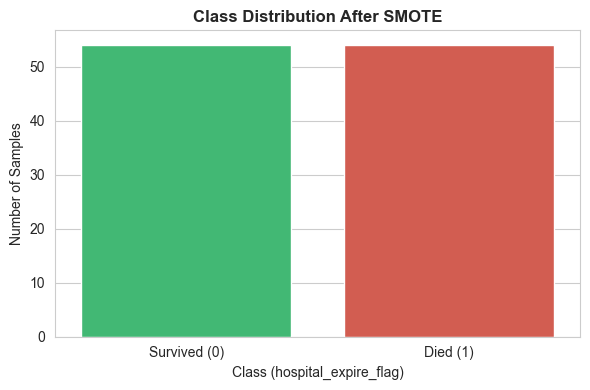


✓ SMOTE applied successfully. Training set is now balanced.


In [13]:
# Apply SMOTE to balance classes in the training set
if 'X_train_scaled_df' in globals() and 'y_train' in globals() and y_train is not None:
    print('\nApplying SMOTE to Training Set')
    print('='*80)
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled_df, y_train)
    
    # Show new class distribution
    from collections import Counter
    class_counts = Counter(y_train_bal)
    print(f'  New class distribution after SMOTE:')
    for label, count in class_counts.items():
        pct = count / len(y_train_bal) * 100
        print(f'    Class {label}: {count:,} ({pct:.2f}%)')
    
    # Bar plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=['#2ecc71', '#e74c3c'])
    plt.title('Class Distribution After SMOTE', fontsize=12, fontweight='bold')
    plt.xlabel('Class (hospital_expire_flag)')
    plt.ylabel('Number of Samples')
    plt.xticks([0, 1], ['Survived (0)', 'Died (1)'])
    plt.tight_layout()
    plt.show()
    
    print('\n✓ SMOTE applied successfully. Training set is now balanced.')
else:
    print('X_train_scaled_df or y_train not available. Cannot apply SMOTE.')

## Section 10b: Class Balancing with SMOTE (Synthetic Minority Over-sampling Technique)

This section applies SMOTE to the training set to address class imbalance, and visualizes the new class distribution.

## Section 11: Final Summary Report

In [14]:
# Final summary
print('\n' + '='*80)
print('EXPLORATORY DATA ANALYSIS - FINAL SUMMARY REPORT')
print('='*80)

print(f'\n DATA SOURCES:')
print(f'  • MIMIC-III Clinical Database (Kaggle Hub)')
print(f'  • Tables: Admissions, Patients, Lab Events, Lab Items')

print(f'\n DATASET OVERVIEW:')
print(f'  • Original admissions: {len(df_admissions) if df_admissions is not None else "N/A":,}')
print(f'  • Unique patients: {len(df_patients) if df_patients is not None else "N/A":,}')
print(f'  • Laboratory events: {len(df_labevents) if df_labevents is not None else "N/A":,}')

print(f'\n DATA QUALITY ASSESSMENT:')
print(f'  ✓ Missing values: Detected and documented')
print(f'  ✓ Duplicates: Removed {len(df_admissions) - len(df_admit_clean) if df_admissions is not None else 0}')
print(f'  ✓ Outliers: Detected using IQR method')
print(f'  ✓ Sparsity: Characterized and imputed')

print(f'\n FINAL DATASET:')

# Safe printing to avoid NameError if train/test split wasn't executed successfully
X_train_exists = 'X_train' in globals() and X_train is not None
X_test_exists = 'X_test' in globals() and X_test is not None

def _fmt_int(x):
    return f"{x:,}" if isinstance(x, int) else str(x)

n_train = len(X_train) if X_train_exists else 'N/A'
n_test = len(X_test) if X_test_exists else 'N/A'
n_features = X_train.shape[1] if X_train_exists and hasattr(X_train, 'shape') else 'N/A'

print(f'  • Training samples: {_fmt_int(n_train)}')
print(f'  • Test samples: {_fmt_int(n_test)}')
print(f'  • Total features: {_fmt_int(n_features)}')
print(f'  • Train-Test split: 80-20' if X_train_exists else '  • Train-Test split: N/A (split not executed)')
print(f'  • Feature scaling: StandardScaler (mean=0, std=1)' if X_train_exists else '  • Feature scaling: N/A')

print(f'\n EXPORTED FILES:')
print(f'  1. data_train.csv - Training dataset')
print(f'  2. data_test.csv - Test dataset')
print(f'  3. data_prepared.csv - Complete dataset with split indicator')
print(f'  4. data_prepared.pkl - Python pickle format')
print(f'  5. data_metadata.json - Metadata and data dictionary')
print(f'\n   Location: {output_dir}')

print(f'\n EDA PROCESS COMPLETED!')
print(f' Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print('='*80)


EXPLORATORY DATA ANALYSIS - FINAL SUMMARY REPORT

 DATA SOURCES:
  • MIMIC-III Clinical Database (Kaggle Hub)
  • Tables: Admissions, Patients, Lab Events, Lab Items

 DATASET OVERVIEW:
  • Original admissions: 129
  • Unique patients: 100
  • Laboratory events: 76,074

 DATA QUALITY ASSESSMENT:
  ✓ Missing values: Detected and documented
  ✓ Duplicates: Removed 0
  ✓ Outliers: Detected using IQR method
  ✓ Sparsity: Characterized and imputed

 FINAL DATASET:
  • Training samples: 80
  • Test samples: 20
  • Total features: 25
  • Train-Test split: 80-20
  • Feature scaling: StandardScaler (mean=0, std=1)

 EXPORTED FILES:
  1. data_train.csv - Training dataset
  2. data_test.csv - Test dataset
  3. data_prepared.csv - Complete dataset with split indicator
  4. data_prepared.pkl - Python pickle format
  5. data_metadata.json - Metadata and data dictionary

   Location: c:\Users\MSI\OneDrive\Desktop\ExamenPractico\processed_data

 EDA PROCESS COMPLETED!
 Timestamp: 2025-12-03 20:48:15


<Figure size 1200x1000 with 0 Axes>

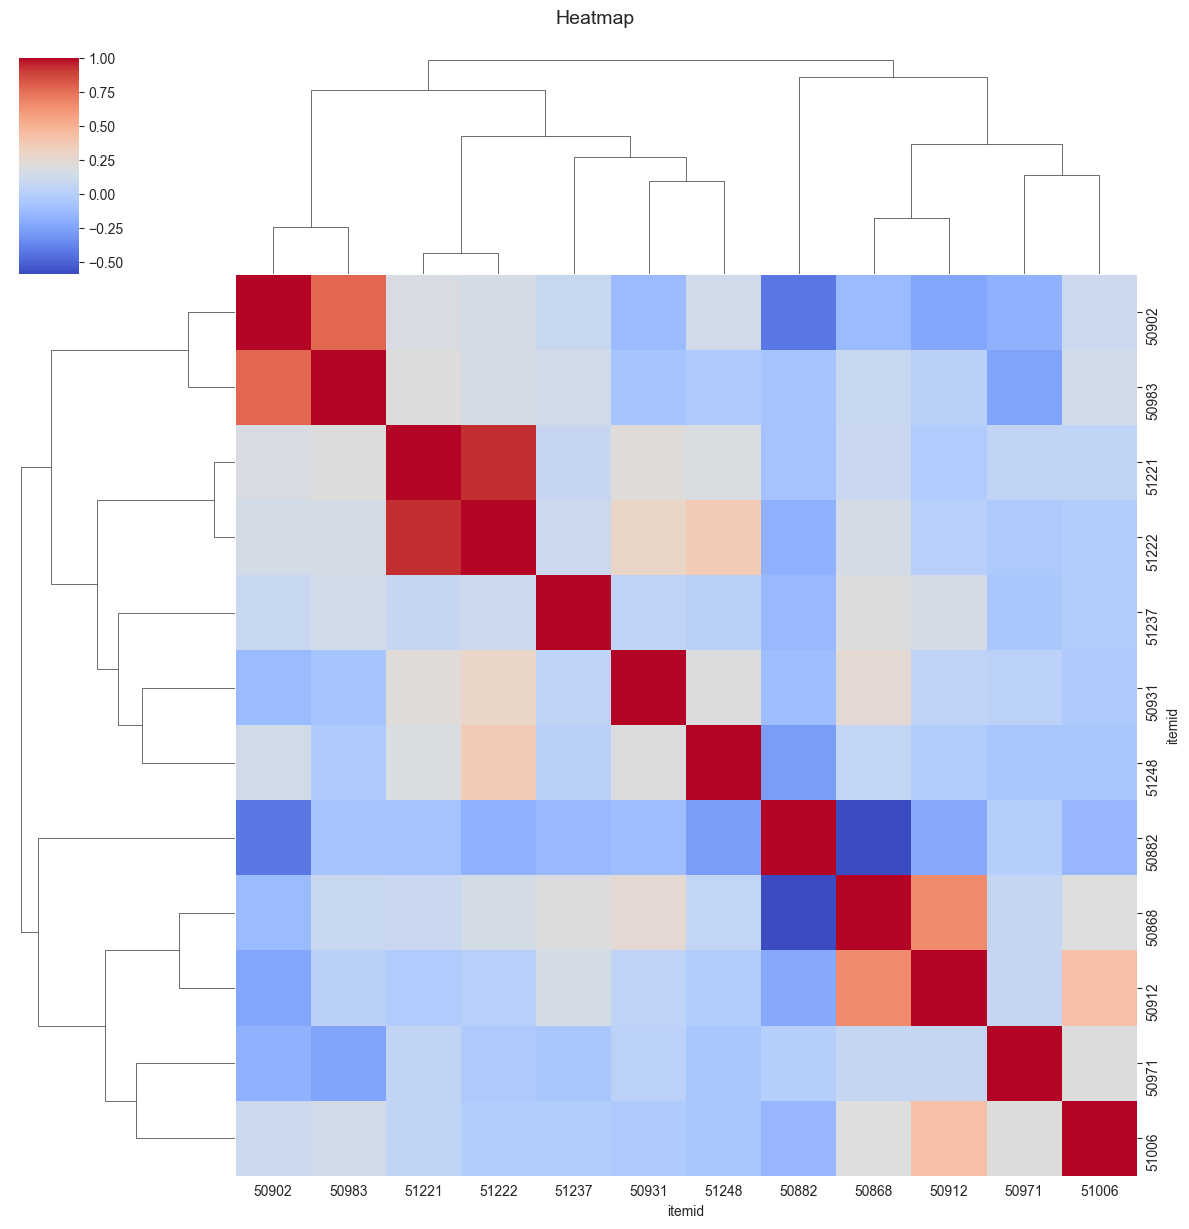

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist

# Usar el mismo pivot_subset del heatmap original:
data = pivot_subset

# Distancias y clustering
dist = pdist(data.T, metric='euclidean')
linkage_matrix = linkage(dist, method='ward')

plt.figure(figsize=(12, 10))
sns.clustermap(data.corr(), cmap="coolwarm", figsize=(12, 12), 
               method="ward", metric="euclidean", annot=False)
plt.suptitle("Heatmap", fontsize=14, y=1.02)
plt.savefig("heatmap_clustered.eps", dpi=300)
plt.show()
